In [1]:
from streaming.models.inputs import SimulationMeasurements
from streaming.models import stream
import numpy as np
import matplotlib.pyplot as plt
import read_clpt 
import pickle
from scipy.interpolate import interp1d
import copy
import pandas as pd

In [2]:
import matplotlib.font_manager
import matplotlib as mpl
mpl.style.use('~/StreamingModel/streaming/utils/mplstyle')
from streaming.utils import plot_tools as pt


In [3]:
pdf_filename = "../data/pairwise_velocity_pdf.hdf5"
tpcf_filename = "../data/tpcf.hdf5"
simulation = SimulationMeasurements(pdf_filename, tpcf_filename)

gaussian = stream.Stream(simulation, 'gaussian')

In [3]:
with open('../perturbation_theory/clpt_params.pkl', 'rb') as f:
    clpt_params = pickle.load( f)

In [4]:
clpt_params

{'b1': 0.29400934909908005,
 'b2': -0.6796955760798071,
 'sigma_fog': -14.607859968801487,
 'linear_growth': 0.5198566749227058}

In [4]:

    
r_clpt, xi_clpt, v12_clpt, s12_par_clpt, s12_perp_clpt = \
                read_clpt.weighted_perturbation_prediction(clpt_params['b1'],
                                                    clpt_params['b2'],
                                                    clpt_params['linear_growth'])

s12_par_clpt += clpt_params['sigma_fog']
s12_perp_clpt += clpt_params['sigma_fog']



In [21]:
clpt_params['sigma_fog']

-14.607859968801487

In [6]:
clpt_moments = {
            'm_10': {'function': interp1d(r_clpt, v12_clpt,
                    bounds_error = False,
                    fill_value = (v12_clpt[2], v12_clpt[-1])), 
                     'popt': ()},
            'c_20': {'function': interp1d(r_clpt[s12_par_clpt > 0.], s12_par_clpt[s12_par_clpt > 0.],
                    bounds_error = False, 
                    fill_value = (s12_par_clpt[s12_par_clpt > 0.][0], s12_par_clpt[-1])),
                     'popt': ()},
            'c_02': {'function': interp1d(r_clpt[s12_perp_clpt > 0.], s12_perp_clpt[s12_perp_clpt > 0.],
                    bounds_error = False,
                    fill_value = (s12_perp_clpt[s12_perp_clpt > 0.][0], s12_perp_clpt[-1])), 'popt': ()},
        }

In [7]:
colors = ['mediumblue', 'lightcoral', 'forestgreen', 'gray']

In [8]:
gaussian_clpt_moments = stream.Stream(simulation, 'gaussian',
                        best_fit_moments = clpt_moments)
gaussian_clpt_moments.label = 'Gaussian-CLPT-Moments'

In [9]:
measured_tpcf = copy.deepcopy(simulation.tpcf.mean)

simulation.tpcf.mean = interp1d(r_clpt, xi_clpt, 
                               bounds_error = False,
                               fill_value = (xi_clpt[0], xi_clpt[-1]))


In [10]:
gaussian_clpt = stream.Stream(simulation, 'gaussian',
                        best_fit_moments = clpt_moments)
gaussian_clpt.label = 'Gaussian-CLPT'

In [11]:
gaussian_clpt_xi = stream.Stream(simulation, 'gaussian')
gaussian_clpt_xi.label = 'Gaussian-CLPT-Xi'

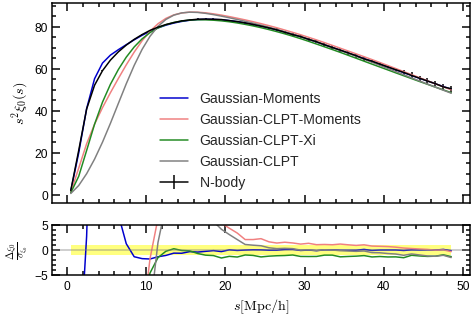

In [12]:
pt.plot_residuals_std(simulation, [gaussian, gaussian_clpt_moments, gaussian_clpt_xi, gaussian_clpt], 
                'monopole', colors = colors)


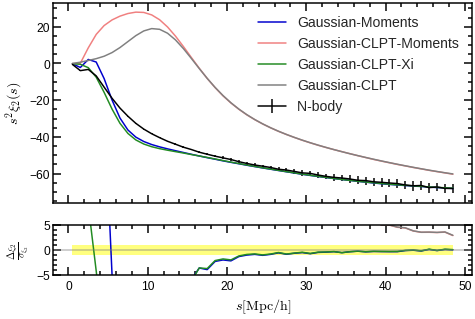

In [13]:
pt.plot_residuals_std(simulation, [gaussian, gaussian_clpt_moments, gaussian_clpt_xi, gaussian_clpt], 
                'quadrupole', colors = colors)

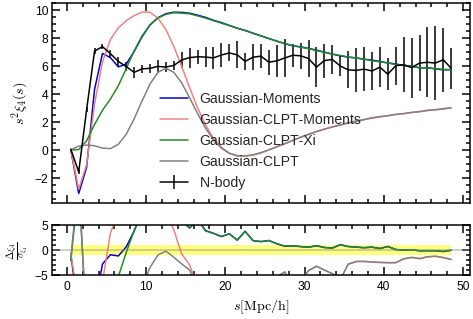

In [14]:
pt.plot_residuals_std(simulation, [gaussian, gaussian_clpt_moments, gaussian_clpt_xi, gaussian_clpt], 
                'hexadecapole', colors = colors)

In [15]:
clpt_results ='/cosma/home/dp004/dc-cues1/CLPT_GSRSD/data/xi_s.txt'

In [31]:
clptcode = pd.read_csv(clpt_results, names = ['r', 'mono','quad','hexa'], sep= ' ')

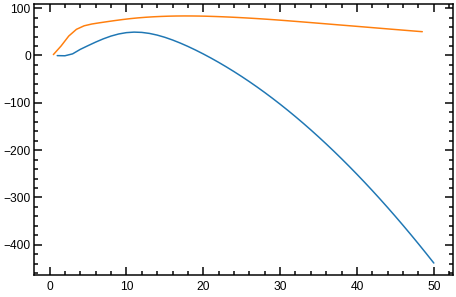

In [32]:
plt.plot(clptcode['r'], clptcode['r']**2 * clptcode['mono'])
plt.plot(simulation.s_c, simulation.s_c**2 * gaussian.monopole)

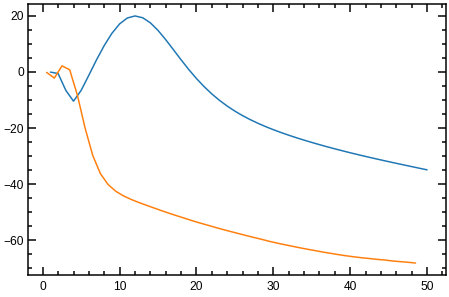

In [33]:
plt.plot(clptcode['r'], clptcode['r']**2 * clptcode['quad'])
plt.plot(simulation.s_c, simulation.s_c**2 * gaussian.quadrupole)

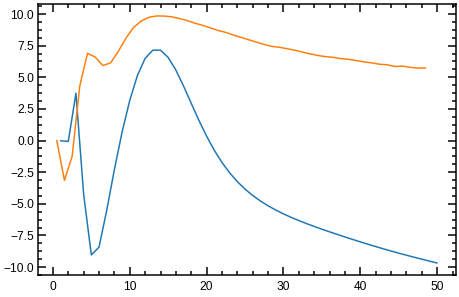

In [34]:
plt.plot(clptcode['r'], clptcode['r']**2 * clptcode['hexa'])
plt.plot(simulation.s_c, simulation.s_c**2 * gaussian.hexadecapole)